# Semantic Based-Regularization 

In this notebook, we will how to implement a simple example of SBR. 

### Example: 
We have a dataset of images containing triangles, squares, and circles, each with some noise.
We will first implement a baseline CNN model to predict the label of each image.
Next, we will compare its performance with a CNN enhanced by Semantic-Based Regularization (CNN-SBR), where logical rules are incorporated as a regularization term in the loss function



In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

# Import modular
%cd ..
from modular import engine
from modular import extra_functions as ef
from modular import model_builder
import modular.samples_setup as cs


/u/ruizsuar/InformedML-CV


In [2]:
# Simulate data
n_samples = [5000] * 3
output = cs.generate_sample(n=n_samples, seed=11, noise_prop=1, var=0.25,
                            Nclass=3)
images, labels= (output['images'], output['labels'])

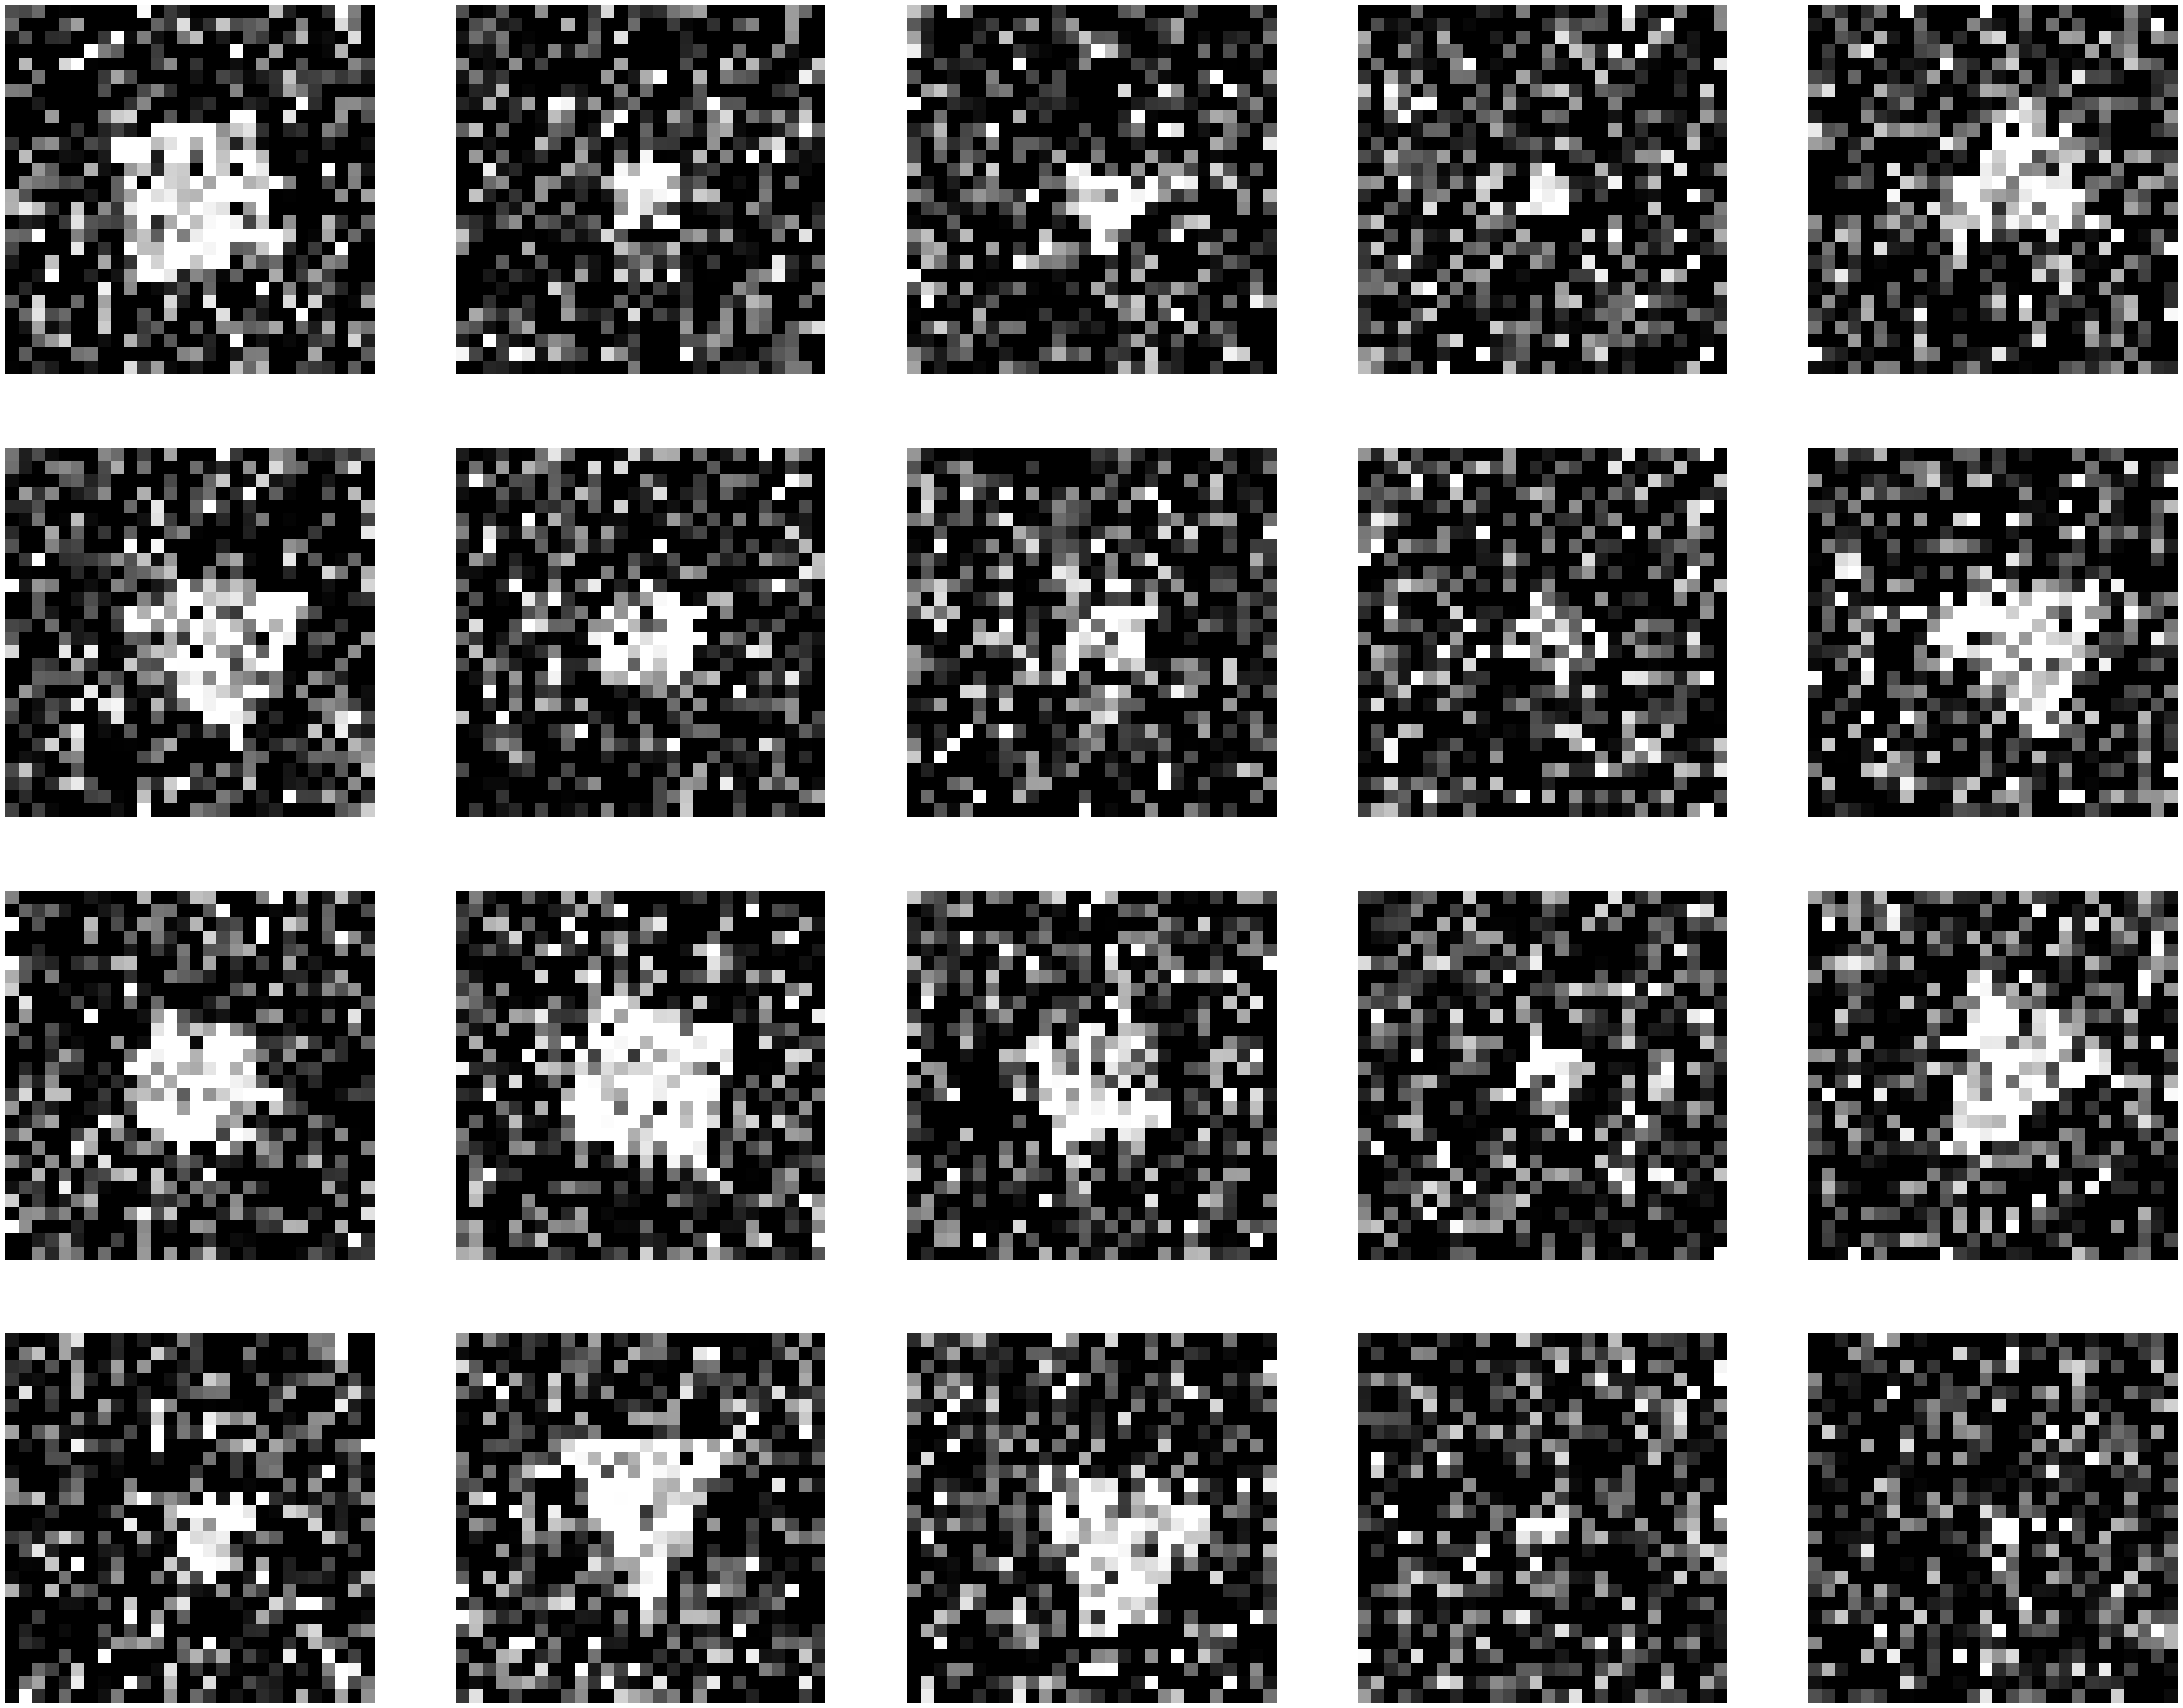

In [3]:
fig, axes = plt.subplots(4, 5, figsize=(50,40))
    
# Flatten the axes array for easier looping
axes = axes.flatten()
    
# Loop through images and axes
for i in range(20):
    axes[i].imshow(images[i], cmap='gray')
    axes[i].axis('off')  # Hide the axes for each image

### We will consider these two classification metrics:
1. Accuracy : $\displaystyle AC(y,\hat{y}) = \frac{1}{N}\sum_{i=1}^N I_{y^{(i)} =\max_j\{\hat{y}_j^{(i)}\}}$

2. Cross entropy:  $\displaystyle CE(y,\hat{y}) = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^C y_j^{(i)}\log(\hat{y}_j^{(i)})$

$\hat{y}^{(i)}$: predicted probability vector of observation $i$

$y^{(i)}$: true label of observation $i$


### Semantic Based-Regularization 
We will add the following rules

* CIRCLE(x) ⇒ ¬ TRIANGLE(x) ∧ ¬ SQUARE(x)
* TRIANGLE(x) ⇒ ¬CIRCLE(x) ∧ ¬SQUARE(x)
* SQUARE(x) ⇒ ¬TRIANGLE(x) ∧ ¬CIRCLE(x)

To do that we first define a regularization term

In [4]:
def semantic_regularization_loss(logits):
    """
    Implements the semantic rule:
    CIRCLE(x) ⇒ ¬TRIANGLE(x) ∧ ¬SQUARE(x)
    TRIANGLE(x) ⇒ ¬CIRCLE(x) ∧ ¬SQUARE(x)
    SQUARE(x) ⇒ ¬TRIANGLE(x) ∧ ¬CIRCLE(x)
    """
    # Apply softmax to logits to get probabilities
    probs = F.softmax(logits, dim=1)

    # Probabilities for each class
    p_circle, p_square, p_triangle = probs[:, 0], probs[:, 1], probs[:, 2]

    # Rule: 
    violation_1 = p_circle * (p_triangle + p_square)
    violation_2 = p_triangle * (p_circle + p_square)
    violation_3 = p_square * (p_triangle + p_circle)

    reg_term = violation_1.mean() + violation_2.mean() + violation_3.mean()
    return reg_term

In [5]:
from typing import Dict, List, Tuple

def train_step_reg(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               alpha: float)-> Tuple[float, float]:
    """Trains a PyTorch model for 1 epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps 

    Args:
        model: A PyTorch model to be trained.
        dataloader: A DataLoader instance for the model to be trained on.
        loss_fn: A PyTorch loss function to minimize.
        optimizer: A PyTorch optimizer to help minimize the loss function.

    Returns:
        A tuple of training loss and training accuracy metrics.
        In the form (train_loss, train_accuracy)
    
  """
    model.train()
    train_loss, train_acc, train_ce= 0, 0, 0

    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Calculate standard loss
        base_loss = loss_fn(y_pred, y)
        # add regularization term
        sbr_loss = semantic_regularization_loss(y_pred)
        loss = base_loss + alpha * sbr_loss
        
        train_loss += loss    # Accumulatively add up the loss per epoch
        
        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

       # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)
        # Calculate Cross entropy
        train_ce += engine.cross_entropy_fn(y_true=y.detach().numpy(),
                                     y_preds=y_pred.detach().numpy()).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    train_ce = train_ce/ len(dataloader)
    return train_loss, train_acc, train_ce


In [6]:

def train_test_loop_reg(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          print_b: True ,
          alpha= float) -> Dict[str, List]:   
    """ Train test loop by epochs.

    Conduct train test loop 

    Args:
        model: A PyTorch model to be used
        train_dataloader: A DataLoader instance for trainig the model
        test_dataloader: A DataLoader instance for testinig the model
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to minimize.
        epochs: Number of epochs to run
        print_b: Boolean. When True the epochs and the test accuracy is printed. 


    Returns:
        A list of train loss, train accuracy metrics, test loss,
        test accuracy metrics.
        In the form (train_loss, train_accuracy,test_loss, test_accuracy)
    
  """
    results = {"train_loss": [],
               "train_acc": [],
               "train_ce": [],
               "test_loss": [],
               "test_acc": [],
               "test_ce": []}
                    
    for epoch in range(epochs):
        train_loss, train_acc, train_ce = train_step_reg(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           alpha = alpha)
        
        test_loss, test_acc, test_ce = engine.test_step(model=model, dataloader=test_dataloader,
                                        loss_fn=loss_fn)

      # Print out what's happening
        if print_b:
            print(
                f"Epoch: {epoch+1} | "
                f"test_acc: {test_acc:.4f}"
            )

      # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_ce"].append(train_ce)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_ce"].append(test_ce)

    return results

### Loop over alpha 

In [ ]:
# Fix variables 

alphas = [0,0.2]
n_reps = 10
n_samples = [[2500]*3]
var_errors = [.25]
prop_errors = [0.5]

# Keep ce and test accuracy
accuracy_test = np.zeros((len(var_errors),len(alphas), len(n_samples) ,n_reps))
ce_test = np.zeros((len(var_errors),len(alphas), len(n_samples) ,n_reps))

BATCH_SIZE = 50
epochs = 6

for v in range(len(var_errors)):
    var = var_errors[v]
    noise_p = prop_errors[v]
    for n in range(len(n_samples)):
        for k in range(n_reps):

            # 1. Simulate images and labels
            output = cs.generate_sample(n=n_samples[n], seed=11, 
                                        noise_prop = noise_p, var=var,
                                        Nclass=3)
            images, labels= (output['images'], output['labels'])
            
                
            # 2. Generate dataset
            train_dataset, test_dataset = cs.generate_dataset(images, labels)
            train_dataloader = DataLoader(train_dataset, 
                                batch_size= 32, 
                                shuffle=True)
            test_dataloader = DataLoader(test_dataset,
                                batch_size= 32,
                                shuffle=True )
            # 3. Load model
            model = model_builder.TVGG(input_shape = 1,
                                hidden_units = 10, 
                                output_shape = 3)
            optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
            loss_fn = nn.CrossEntropyLoss()
            
            for a in range(len(alphas)):
                alpha = alphas[a]
                # 4. Run model 
                output = train_test_loop_reg(model,train_dataloader,test_dataloader,
                                optimizer, loss_fn, epochs,print_b=False,
                                alpha = alpha)
                

                accuracy_test[v,a,n,k]  = output['test_acc'][epochs-1]  
                ce_test[v,a,n,k]  = output['test_ce'][epochs-1]  

            
        

AttributeError: 'numpy.ndarray' object has no attribute 'errorbar'

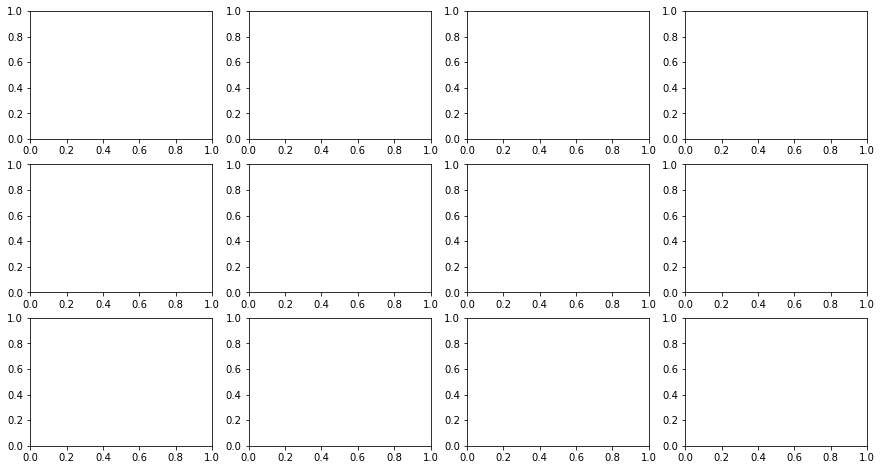

In [31]:
import matplotlib.pyplot as plt
quantiles = [0.2, 0.5, 0.8]  
quantile_array_acc = np.quantile(accuracy_test, q=quantiles, axis=3)
mean_array_acc = np.mean(accuracy_test, axis=3)
sd_array_acc = np.std(accuracy_test, axis=3)
quantile_array_ce = np.quantile(ce_test, q=quantiles, axis=3)
mean_array_ce = np.mean(ce_test, axis=3)

# Plot accuracy
fig, axes = plt.subplots(len(var_errors),len(n_samples), figsize=(15, 8))

x_offsets = sequence = np.arange(0, len(alphas)*0.1,0.1)
# Offsets for each plot on the x-axis


for j in range(len(alphas)):
    
    median = quantile_array_acc[1,v,j,i]
    lower_error = median - quantile_array_acc[0,v,j,i] 
    upper_error = quantile_array_acc[2,v,j,i] - median
    errors = [[lower_error], [upper_error]]  
    axes.errorbar(x=x_offsets[j],  
                y=[median],
                yerr=errors,
                fmt='o',  
                capsize=5,
            )

    axes.legend(alphas)
    axes.set_title(f'N sample = {n_samples[i]}')
    axes.set(ylabel = f'Test Accuracy\n var_error = {var_errors[v]}')
    axes.set_xticks([])  


AttributeError: 'numpy.ndarray' object has no attribute 'errorbar'

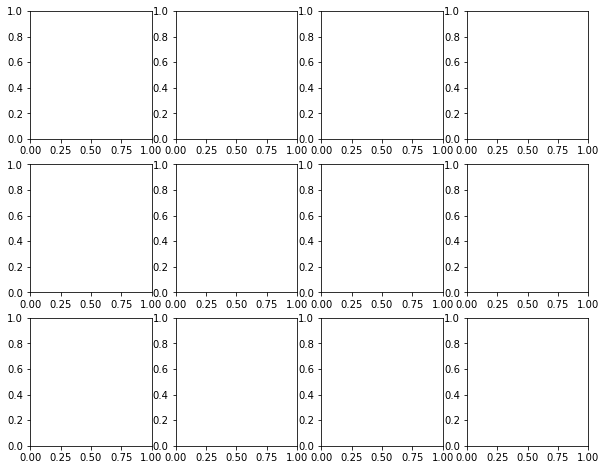

In [ ]:
# Plot Cross-Entropy
fig, axes = plt.subplots(len(var_errors),len(n_samples), figsize=(10, 8))

x_offsets = sequence = np.arange(0, len(alphas)*0.1,0.1)
 # Offsets for each plot on the x-axis


for j in range(len(alphas)):
    median = quantile_array_ce[1,v,j,i]
    lower_error = median - quantile_array_ce[0,v,j,i] 
    upper_error = quantile_array_ce[2,v,j,i] - median

    errors = [[lower_error], [upper_error]]  


    axes.errorbar(x=x_offsets[j],  
                y=[mean],
                yerr=errors,
                fmt='o',  
                capsize=5,
            )
    axes.legend(alphas)
    axes.set_title(f'N sample = {n_samples[i]}')
    axes.set(ylabel = f'Test CE\n var_error = {var_errors[v]}')
    axes.set_xticks([])  

    
    